# Chapter 3 – Classification

* Train a binary classification model 

* Model performance measure and error analysis 

* Multi-label classification 



## Train a binary model 

In [4]:
# override the default warnings setting 
# https://docs.python.org/3/library/warnings.html
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [5]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [6]:
type(mnist)

sklearn.utils.Bunch

In [7]:
# X includes all features (pixels of each digit number), y is the label 
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

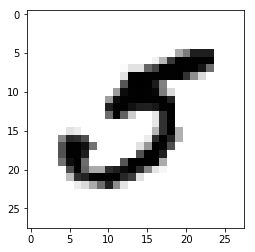

In [11]:
# show a digit in image format 
digit = X[36000]
digit_image = digit.reshape(28, -1)
plt.imshow(digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.show()

In [12]:
y[36000] # corresponding label 

5.0

In [13]:
# split the data into train and test 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
# shuffle the training set to make sure all cross-validation folds are similar 
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier
Train a classifier to classify label 5 from all other different labels.


In [15]:
# create label 
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
# use stochastic gradient descent classifier 
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
# make prediction on the previously extracted image features 
sgd_clf.predict([digit])

array([ True])

In [19]:
# check model performance based on accuracy
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

In [23]:
# make predictions with cross_val_predict
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)

[False False False ... False False False]


In [24]:
# compute confusion matrix 
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [25]:
# compute the precision 
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # precision is low even accuracy is high 

0.7687135020350381

In [26]:
# the above is equivalent with 
4344 / (4344 + 1307)

0.7687135020350381

In [27]:
# compute recall 
recall_score(y_train_5, y_train_pred)

0.801328168234643

In [28]:
# or 
4344 / (4344 + 1077)

0.801328168234643

In [29]:
# compute f1 score 
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [31]:
# decision_function() returns a score for each instance/observation
y_scores = sgd_clf.decision_function([digit])
y_scores

array([161855.74572176])

In [34]:
# compute decision scores for all instances 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
print(y_scores)

[ -434076.49813641 -1825667.15281624  -767086.76186905 ...
  -867191.25267994  -565357.11420164  -366599.16018198]


### Plot PR curve 

In [35]:
# compute precision and recall for each different threshold of y_scores
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

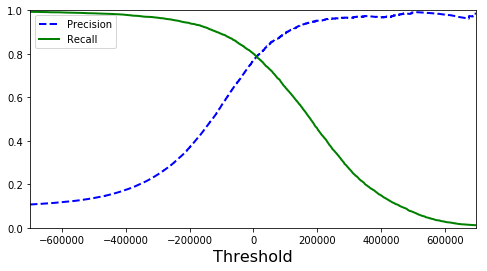

In [39]:
# plot 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=10)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

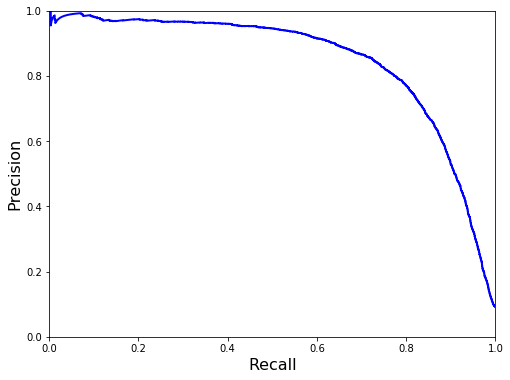

In [40]:
# define a function to plot precision vs recall 
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC curves

In [47]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

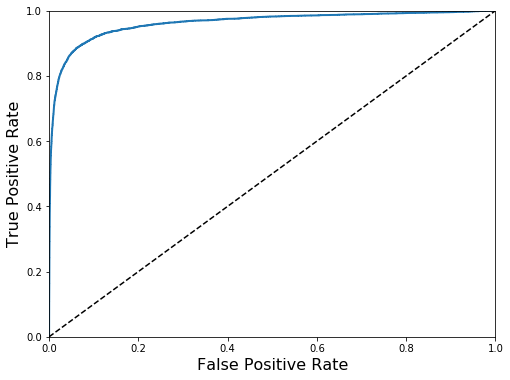

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [50]:
# area under curve (AUC)
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967156

### Multiclass classification

In [51]:
# use all labels (y_train) to automatically run one vs all classification 
sgd_clf.fit(X_train, y_train)
# predict
sgd_clf.predict([digit])

array([5.])

In [52]:
# check the decision scores for all classes when making prediction 
digit_scores = sgd_clf.decision_function([digit])
digit_scores # class with label 5 has the highest score 

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [53]:
# class with label 5 has the highest score 
np.argmax(digit_scores)

5

In [54]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [55]:
sgd_clf.classes_[5]

5.0

In [58]:
# one vs one classifier 
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([digit])

array([5.])

In [59]:
# C(10, 2) pairs of classifiers to be estimated 
len(ovo_clf.estimators_)

45

In [60]:
###############################################
# Standardize the inputs for better prediction
###############################################
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

#### Error analysis 

In [61]:
# make predictions for multiclasses and compute confusion matrix 
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

In [65]:
# function to plot confusion matrix 
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

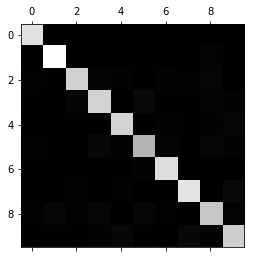

In [66]:
# plot 
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show() # not clear for errors analysis 

In [67]:
# remove the correct predictions and focus on errors 
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

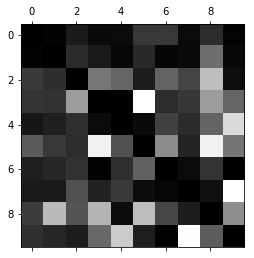

In [68]:
# error densities
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel classification

In [69]:
from sklearn.neighbors import KNeighborsClassifier
# create two labels
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [71]:
# make predictions
knn_clf.predict([digit])

array([[False,  True]])

In [72]:
# use cross validation
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525002

# Multioutput classification

In [73]:
# make up some noise 
noise = np.random.randint(0, 100, (len(X_train), 784))
# use noisy training set as input 
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# use original training set as output
y_train_mod = X_train
y_test_mod = X_test

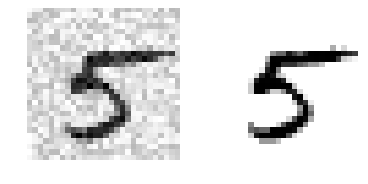

In [75]:
# plot input and output of a digit 
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

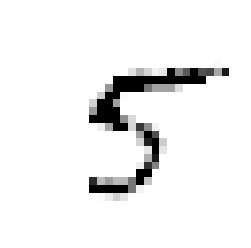

In [76]:
# train model to see the if it can clean the data 
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
